In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

TODO: 
* Load model
* Plot intensity distribution
* Evaluate a good threshold (Weakly Supervised Deep Learning for Segmentationof Remote Sensing Imagery)

Some help:
https://stackoverflow.com/questions/64617205/merging-each-instance-mask-back-to-the-original-image-python
https://stackoverflow.com/questions/61383095/create-mask-or-boundary-from-each-other-in-python3

In [20]:
from src.utils.utils import tensor2numpy
from src.utils.preprocess import mask_threshold
from src.segmentation import cam
from src.classifier.agent import load_trainer
import nibabel as nib
from src.segmentation.cam import CAMS


In [101]:
trainer, dataset, model = load_trainer('resnet50');
tmp_image = nib.load('../data/SPM_categorised/AIH/AD/AD_ADNI_2975.nii').get_fdata()
tmp = cam.CAM(CAMS.GradCAMpp.value, model, tmp_image)

grid_image, grid_mask = tmp.grid_class(tmp.class_scores, 2)

Loading model from /home/stud1/f/fremar16/Master_thesis/logs/tb/resnet50/version_1/checkpoints/checkpoint-v2.ckpt (checkpoint)..


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.


Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet50', 'args': {}}
"callbacks":           ['litprogressbar', 'modelcheckpoints', 'metriccallback']
"checkpoint_path":     None
"class_weights":       None
"hp_metrics":          ['loss', 'loss', 'accuracy', 'auc', 'specificity', 'sensitivity']
"kfold":               {'enable': False, 'folds': 10}
"loss":                CrossEntropyLoss
"loss_weight_balance": None
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.0002, 'weight_decay': 1e-05, 'amsgrad': True}}
Dataset sizes - Training: 421 Validation: 47
3


/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


## Plot image distribution

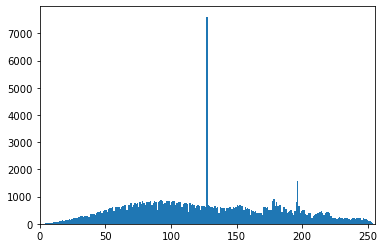

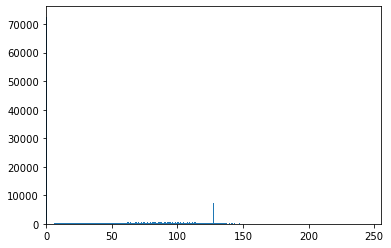

In [165]:
import matplotlib.pyplot as plt
#plt.imshow(grid_mask)

def intensity_distribution(image):
    b, bins, patches = plt.hist(image, 255)
    plt.xlim([0,255])
    plt.show()
    
intensity_distribution(tensor2numpy(grid_mask).flatten())

intensity_distribution(tensor2numpy(grid_image).flatten())

# Segment mask

In [213]:
tmp_mask = tensor2numpy(grid_mask).copy()

def create_cam_mask(image, mask):
    """Create a mask from CAM. Select top 20% of the activations and remove activations which are a part of the background of brain scan
    
    Return:
        * Mask with reduced activations
    """
    t_mask = mask_threshold(tmp_mask,0.8)
    t_mask[grid_image == 0] = 0#np.nan
    t_mask[t_mask == 0] = 0#np.nan
    return t_mask

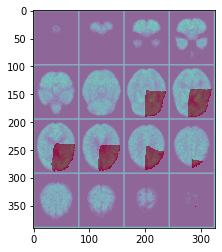

In [223]:
from src.utils.plots.parula import parula_map
from matplotlib import colors

t_mask = create_cam_mask(grid_image, grid_mask)

plt.imshow(grid_image)
plt.imshow(t_mask, alpha=0.4, cmap=colors.ListedColormap(['white','red']), interpolation = 'none', vmin = 0.1)

In [217]:
import numpy as np
mask_to_bb(t_mask)

array([141.,  33., 351., 319.], dtype=float32)

In [208]:
np.nonzero(t_mask)

(array([  0,   0,   0, ..., 389, 389, 389]),
 array([  0,   1,   2, ..., 323, 324, 325]))

In [216]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    #cols, rows = np.isnan(Y)
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

def fuse_images():
    """Fuse a list of images to one image with the average intensity over image."""
    pass


In [ ]:
label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=CN, 2=MCI, 3=AD
               (128, 0, 0), (0, 128, 0), (128, 128, 0)])